In [47]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.005
MOMENTUM = 0.9
EPOCHS = 25

In [3]:
def create_image_pairs(dataset):
    image_pairs = []
    labels = []

    max_size_class = len(dataset) // 3  # Limita il numero massimo di campioni per ciascuna classe
    count_class_0 = 0  # Contatore per la classe A > B
    count_class_1 = 0  # Contatore per la classe A < B
    count_class_2 = 0  # Contatore per la classe A = B
    i = 0
    
    # Continua finché tutte le classi non sono bilanciate
    while count_class_0 < max_size_class or count_class_1 < max_size_class or count_class_2 < max_size_class:
        img_A, label_A = dataset[i]

        class_busy = True
        while class_busy:  # Cerca una relazione valida che non sia satura
            idx_B = random.randint(0, len(dataset) - 1)
            img_B, label_B = dataset[idx_B]

            # Determina la relazione tra le etichette
            if label_A > label_B:
                relation_label = 0  # A > B
            elif label_A < label_B:
                relation_label = 1  # A < B
            else:
                relation_label = 2  # A = B

            # Verifica se la classe ha già raggiunto il limite massimo
            if relation_label == 0 and count_class_0 < max_size_class:
                count_class_0 += 1
                class_busy = False
            elif relation_label == 1 and count_class_1 < max_size_class:
                count_class_1 += 1
                class_busy = False
            elif relation_label == 2 and count_class_2 < max_size_class:
                count_class_2 += 1
                class_busy = False

        # Aggiungi la coppia solo se la classe non ha raggiunto il limite massimo
        image_pairs.append((img_A, img_B))
        labels.append(relation_label)
        i += 1

    return image_pairs, labels


In [4]:
# Dataset personalizzato per gestire le coppie di immagini
class MNISTPairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.image_pairs, self.labels = create_image_pairs(dataset)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_A, img_B = self.image_pairs[idx]
        label = self.labels[idx]

        # Concatenare le immagini lungo il canale (depth)
        concatenated_image = torch.cat((img_A, img_B), dim=0)

        return concatenated_image, label


In [5]:
# Funzione per visualizzare una coppia di immagini e la loro etichetta di relazione
def show_image_pair(img_A, img_B, relation_label):
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Converte il tensore in numpy array per visualizzazione
    img_A = img_A.squeeze().numpy()  # Rimuove la dimensione del canale
    img_B = img_B.squeeze().numpy()

    # Crea una figura con due immagini, riducendo la dimensione per occupare meno spazio
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))  # Dimensioni ridotte

    # Mostra le immagini
    axes[0].imshow(img_A, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')  # Rimuove gli assi

    axes[1].imshow(img_B, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')  # Rimuove gli assi

    # Riduce lo spazio tra i subplots
    plt.tight_layout(pad=0.5)  # Riduce il padding tra le immagini

    # Mostra il titolo della relazione
    plt.suptitle(f'Relation: {relation_labels[relation_label]}', y=0.85)  # Posiziona il titolo più vicino
    plt.show()


In [6]:
# Funzione per visualizzare più coppie di immagini in un'unica figura
def show_dataset(dataset, num_images=5):
    dataiter = iter(dataset)
    images, labels = next(dataiter)

    # Mappa delle etichette di relazione
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Numero di righe: ogni riga contiene 1 coppia di immagini (2 colonne)
    num_rows = num_images  # 1 coppia per riga

    # Crea una griglia di subplots: num_rows righe, 3 colonne (Image A, Relation, Image B)
    fig, axes = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    
    for i in range(num_images):
        concatenated_image = images[i]
        label = labels[i].item()

        img_A = concatenated_image[0, :, :]
        img_B = concatenated_image[1, :, :]

        # Mostra l'immagine A nel subplot
        axes[i, 0].imshow(img_A, cmap='gray')
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        # Mostra l'etichetta di relazione nel subplot centrale
        axes[i, 1].text(0.5, 0.5, f'Relation: {relation_labels[label]}', 
                        fontsize=12, ha='center', va='center')
        axes[i, 1].axis('off')

        # Mostra l'immagine B nel subplot
        axes[i, 2].imshow(img_B, cmap='gray')
        axes[i, 2].set_title('Image B')
        axes[i, 2].axis('off')  # Nascondi gli assi

    # Applica il layout compatto per ridurre lo spazio tra i subplot
    plt.tight_layout(pad=0.5)
    plt.show()
    return fig


In [7]:
def dataset_statistics(dataset):
    class_counts = collections.Counter()
    image_shapes = set()
    pair_relations_counts = collections.Counter()

    for img_pair, label in dataset:
        # Aggiorna la distribuzione delle classi
        pair_relations_counts[label] += 1

        # Controlla la dimensione delle immagini
        image_shapes.add(img_pair.shape)

    # Riassumi le informazioni
    total_samples = len(dataset)
    class_distribution = dict(pair_relations_counts)

    print(f"Numero totale di campioni: {total_samples}")
    print(f"Distribuzione delle relazioni (A > B, A < B, A = B): {class_distribution}")
    print(f"Dimensioni delle immagini trovate nel dataset: {image_shapes}")

    # Calcolo delle percentuali delle classi
    for relation, count in class_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"Relazione {relation}: {count} campioni ({percentage:.2f}%)")
    
    print("\n")
    return class_distribution, image_shapes


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset_statistics(dataset, dataset_name="Dataset"):
    # Ottieni le statistiche con la funzione precedente
    class_distribution, image_shapes = dataset_statistics(dataset)
    
    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")
    
    # 1. Istogramma della distribuzione delle classi (relazioni A > B, A < B, A = B)
    plt.figure(figsize=(10, 6))
    classes = ['A > B', 'A < B', 'A = B']
    counts = [class_distribution.get(0, 0), class_distribution.get(1, 0), class_distribution.get(2, 0)]
    
    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()
    
    # 3. Box plot per esplorare la distribuzione delle classi in percentuale
    plt.figure(figsize=(10, 6))
    percentages = [(count / len(dataset)) * 100 for count in counts]
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale di Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()

In [9]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [10]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [45]:
def create_train_dataset(transform_dataset=False, augment_dataset=False):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

    transform_augmented = transforms.Compose([
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.RandomChoice([
            transforms.Lambda(lambda x: add_gaussian_noise(x)),
            transforms.Lambda(lambda x: invert_colors(x)),
            transforms.Lambda(lambda x: x),
        ]),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)
    
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_augmented)

    train_pair_dataset = MNISTPairDataset(train_dataset)
    train_pair_dataset_augmented = MNISTPairDataset(train_dataset_augmented)

    print(f"Dimensione del dataset originale: {len(train_pair_dataset)}")
    print(f"Dimensione del dataset trasformato: {len(train_pair_dataset_augmented)}")

    if augment_dataset:
        train_pair_dataset = torch.utils.data.ConcatDataset([train_pair_dataset, train_pair_dataset_augmented])
        print(f"Dimensione del dataset combinato: {len(train_pair_dataset)}")
    
    if transform_dataset:
        train_pair_dataset = train_pair_dataset_augmented

    return train_pair_dataset, train_dataset


In [46]:
def create_test_dataset(validation_split=0.2):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
    
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

    test_pair_dataset = MNISTPairDataset(test_dataset)

    total_test_size = len(test_pair_dataset)
 
    validation_size = int(total_test_size * validation_split)
    test_size = total_test_size - validation_size

    test_subset, validation_subset = torch.utils.data.random_split(test_pair_dataset, [test_size, validation_size])
    return test_subset, validation_subset, test_dataset

In [13]:
def create_data_loader(train_dataset, validation_dataset, test_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader

In [16]:
train_dataset, train_dataset_raw = create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = create_test_dataset(validation_split=0.3)

Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 28, 28])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




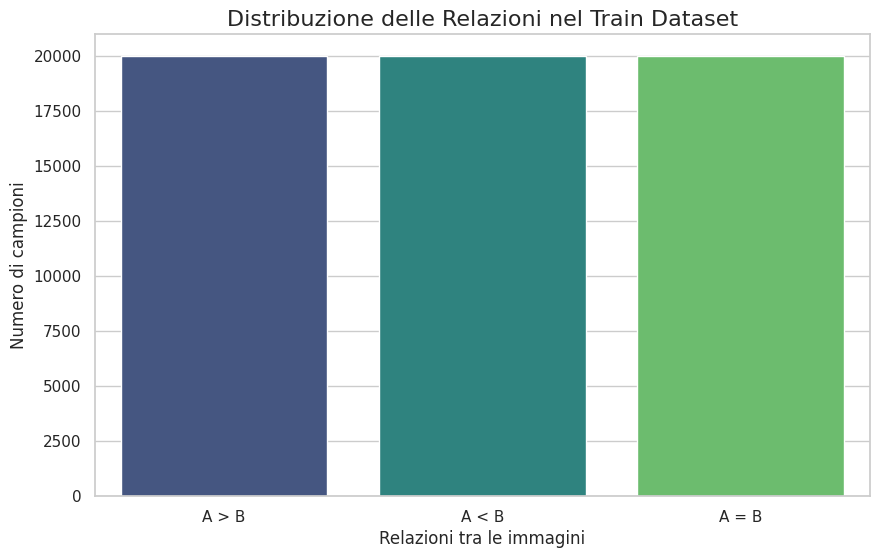

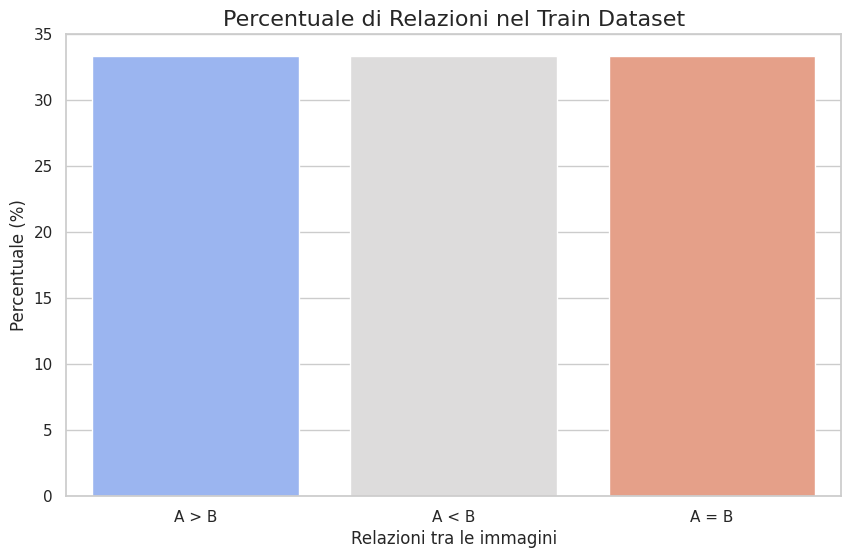

In [17]:
plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 2302, 0: 2378, 2: 2320}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 28, 28])}
Relazione 1: 2302 campioni (32.89%)
Relazione 0: 2378 campioni (33.97%)
Relazione 2: 2320 campioni (33.14%)




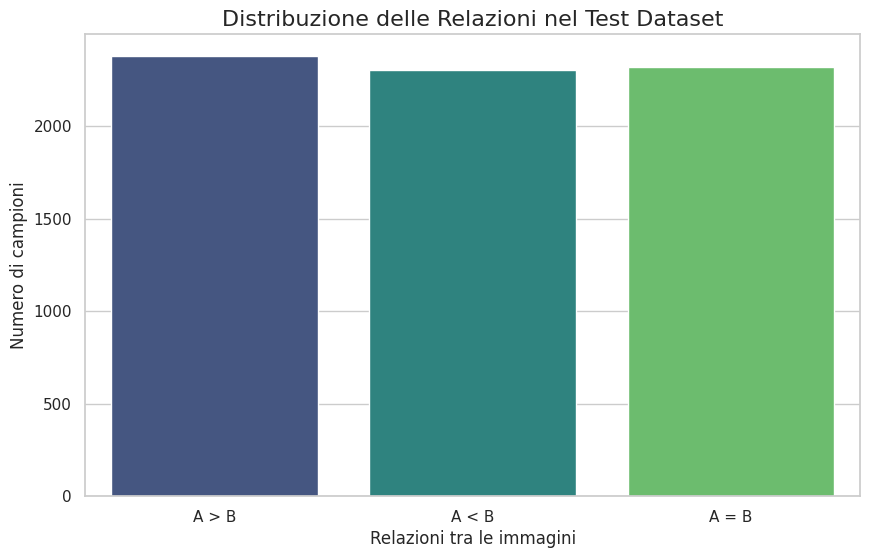

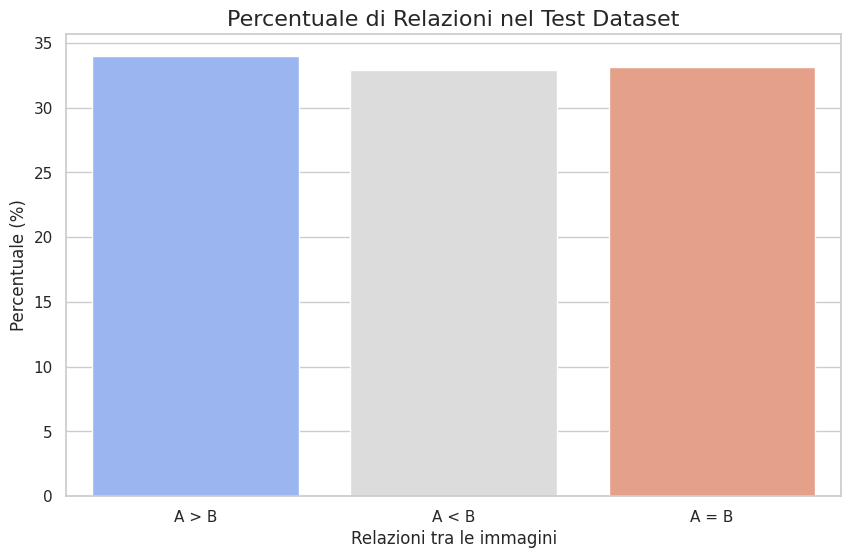

In [18]:
plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 2999
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 1031, 0: 955, 2: 1013}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 28, 28])}
Relazione 1: 1031 campioni (34.38%)
Relazione 0: 955 campioni (31.84%)
Relazione 2: 1013 campioni (33.78%)




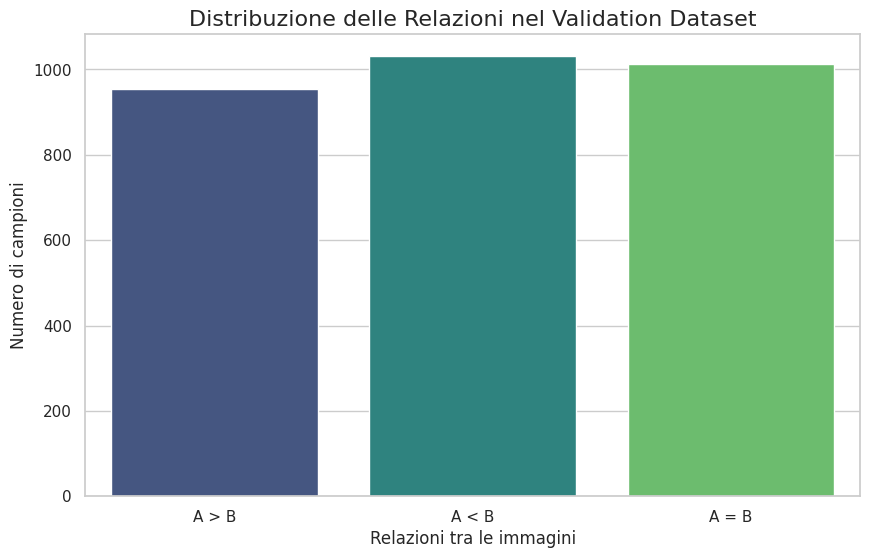

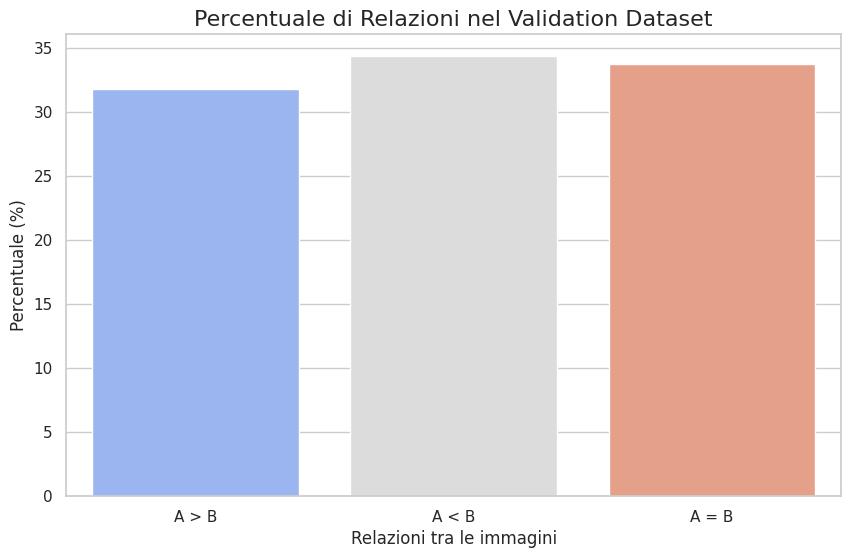

In [19]:
plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [20]:
train_loader, validation_loader, test_loader = create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [21]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  24  Size validation_dataset:  2999
Size test_loader:  55  Size test_dataset:  7000


In [184]:
#if PRINT_IMG:
#    show_dataset(train_loader, 10)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [49]:
import torch.nn as nn
import torch.nn.functional as F

class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [50]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

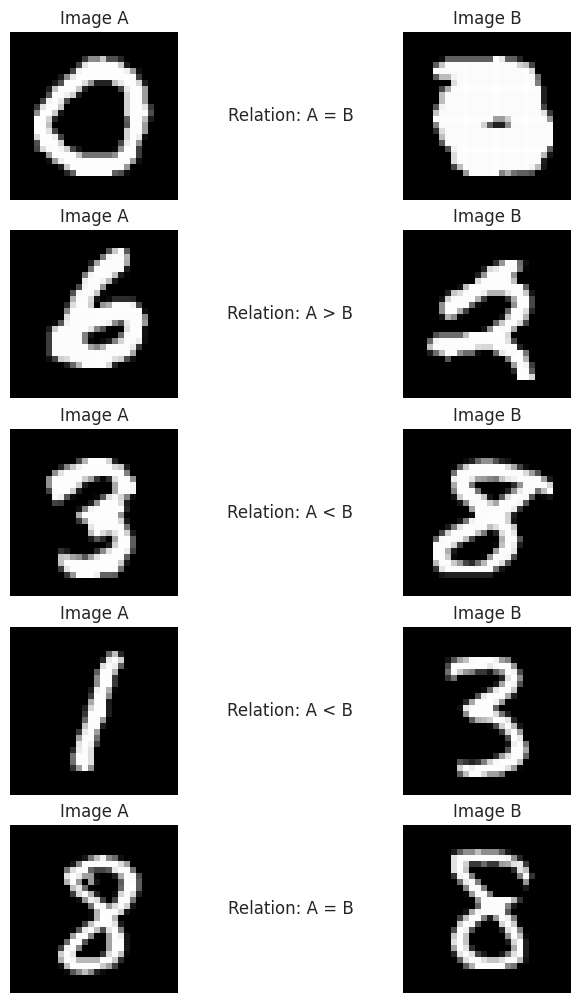

In [51]:
from torch.utils.tensorboard import SummaryWriter

fileName = f"runs/log_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}"
writer = SummaryWriter(fileName)

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', show_dataset(train_loader, 5))

In [52]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [53]:
# TRAIN!!!
import time
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 25
Training


Loss: 0.6908: 100%|██████████| 469/469 [00:08<00:00, 56.54it/s]


Validating


Loss: 0.5833: 100%|██████████| 24/24 [00:00<00:00, 100.45it/s]


Epoch #1 train loss: 0.893 train accuracy: 57.32
Epoch #1 validation loss: 0.583 validation accuracy: 71.76
Took 0.142 minutes for epoch 1

EPOCH 2 of 25
Training


Loss: 0.5458: 100%|██████████| 469/469 [00:08<00:00, 57.36it/s]


Validating


Loss: 0.4178: 100%|██████████| 24/24 [00:00<00:00, 123.76it/s]


Epoch #2 train loss: 0.581 train accuracy: 76.26
Epoch #2 validation loss: 0.418 validation accuracy: 80.36
Took 0.140 minutes for epoch 2

EPOCH 3 of 25
Training


Loss: 0.5254: 100%|██████████| 469/469 [00:08<00:00, 57.94it/s]


Validating


Loss: 0.3510: 100%|██████████| 24/24 [00:00<00:00, 83.72it/s]


Epoch #3 train loss: 0.439 train accuracy: 82.75
Epoch #3 validation loss: 0.351 validation accuracy: 85.46
Took 0.140 minutes for epoch 3

EPOCH 4 of 25
Training


Loss: 0.2504: 100%|██████████| 469/469 [00:07<00:00, 58.71it/s]


Validating


Loss: 0.2947: 100%|██████████| 24/24 [00:00<00:00, 118.91it/s]


Epoch #4 train loss: 0.344 train accuracy: 86.72
Epoch #4 validation loss: 0.295 validation accuracy: 88.36
Took 0.137 minutes for epoch 4

EPOCH 5 of 25
Training


Loss: 0.2640: 100%|██████████| 469/469 [00:08<00:00, 57.80it/s]


Validating


Loss: 0.2931: 100%|██████████| 24/24 [00:00<00:00, 121.71it/s]


Epoch #5 train loss: 0.285 train accuracy: 89.22
Epoch #5 validation loss: 0.293 validation accuracy: 89.23
Took 0.139 minutes for epoch 5

EPOCH 6 of 25
Training


Loss: 0.1453: 100%|██████████| 469/469 [00:08<00:00, 57.02it/s]


Validating


Loss: 0.2557: 100%|██████████| 24/24 [00:00<00:00, 72.76it/s]


Epoch #6 train loss: 0.242 train accuracy: 91.04
Epoch #6 validation loss: 0.256 validation accuracy: 90.76
Took 0.143 minutes for epoch 6

EPOCH 7 of 25
Training


Loss: 0.1769: 100%|██████████| 469/469 [00:09<00:00, 47.28it/s]


Validating


Loss: 0.2732: 100%|██████████| 24/24 [00:00<00:00, 78.58it/s]


Epoch #7 train loss: 0.212 train accuracy: 92.15
Epoch #7 validation loss: 0.273 validation accuracy: 90.83
Took 0.171 minutes for epoch 7

EPOCH 8 of 25
Training


Loss: 0.2515: 100%|██████████| 469/469 [00:09<00:00, 47.32it/s]


Validating


Loss: 0.1943: 100%|██████████| 24/24 [00:00<00:00, 82.90it/s]


Epoch #8 train loss: 0.185 train accuracy: 93.33
Epoch #8 validation loss: 0.194 validation accuracy: 92.06
Took 0.170 minutes for epoch 8

EPOCH 9 of 25
Training


Loss: 0.1510: 100%|██████████| 469/469 [00:09<00:00, 49.08it/s]


Validating


Loss: 0.2224: 100%|██████████| 24/24 [00:00<00:00, 95.55it/s] 


Epoch #9 train loss: 0.166 train accuracy: 93.91
Epoch #9 validation loss: 0.222 validation accuracy: 92.86
Took 0.164 minutes for epoch 9

EPOCH 10 of 25
Training


Loss: 0.1029: 100%|██████████| 469/469 [00:10<00:00, 45.60it/s]


Validating


Loss: 0.2640: 100%|██████████| 24/24 [00:00<00:00, 94.88it/s]


Epoch #10 train loss: 0.151 train accuracy: 94.60
Epoch #10 validation loss: 0.264 validation accuracy: 92.00
Took 0.176 minutes for epoch 10

EPOCH 11 of 25
Training


Loss: 0.0775: 100%|██████████| 469/469 [00:10<00:00, 46.54it/s]


Validating


Loss: 0.2957: 100%|██████████| 24/24 [00:00<00:00, 92.81it/s]


Epoch #11 train loss: 0.134 train accuracy: 95.15
Epoch #11 validation loss: 0.296 validation accuracy: 92.06
Took 0.172 minutes for epoch 11

EPOCH 12 of 25
Training


Loss: 0.0870: 100%|██████████| 469/469 [00:09<00:00, 50.60it/s]


Validating


Loss: 0.2180: 100%|██████████| 24/24 [00:00<00:00, 99.37it/s] 


Epoch #12 train loss: 0.122 train accuracy: 95.54
Epoch #12 validation loss: 0.218 validation accuracy: 92.70
Took 0.159 minutes for epoch 12

EPOCH 13 of 25
Training


Loss: 0.1023: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s]


Validating


Loss: 0.2147: 100%|██████████| 24/24 [00:00<00:00, 85.34it/s]


Epoch #13 train loss: 0.113 train accuracy: 95.88
Epoch #13 validation loss: 0.215 validation accuracy: 92.93
Took 0.221 minutes for epoch 13

EPOCH 14 of 25
Training


Loss: 0.0659: 100%|██████████| 469/469 [00:09<00:00, 47.51it/s]


Validating


Loss: 0.2013: 100%|██████████| 24/24 [00:00<00:00, 79.75it/s]


Epoch #14 train loss: 0.101 train accuracy: 96.33
Epoch #14 validation loss: 0.201 validation accuracy: 91.30
Took 0.170 minutes for epoch 14

EPOCH 15 of 25
Training


Loss: 0.1481: 100%|██████████| 469/469 [00:09<00:00, 47.12it/s]


Validating


Loss: 0.2123: 100%|██████████| 24/24 [00:00<00:00, 59.62it/s]


Epoch #15 train loss: 0.089 train accuracy: 96.81
Epoch #15 validation loss: 0.212 validation accuracy: 93.40
Took 0.173 minutes for epoch 15

EPOCH 16 of 25
Training


Loss: 0.0801: 100%|██████████| 469/469 [00:09<00:00, 50.82it/s]


Validating


Loss: 0.2802: 100%|██████████| 24/24 [00:00<00:00, 88.51it/s] 


Epoch #16 train loss: 0.082 train accuracy: 96.98
Epoch #16 validation loss: 0.280 validation accuracy: 93.03
Took 0.159 minutes for epoch 16

EPOCH 17 of 25
Training


Loss: 0.1029: 100%|██████████| 469/469 [00:09<00:00, 50.20it/s]


Validating


Loss: 0.2083: 100%|██████████| 24/24 [00:00<00:00, 101.66it/s]


Epoch #17 train loss: 0.076 train accuracy: 97.29
Epoch #17 validation loss: 0.208 validation accuracy: 92.96
Took 0.160 minutes for epoch 17

EPOCH 18 of 25
Training


Loss: 0.1003: 100%|██████████| 469/469 [00:09<00:00, 50.63it/s]


Validating


Loss: 0.2230: 100%|██████████| 24/24 [00:00<00:00, 103.66it/s]


Epoch #18 train loss: 0.071 train accuracy: 97.38
Epoch #18 validation loss: 0.223 validation accuracy: 93.40
Took 0.158 minutes for epoch 18

EPOCH 19 of 25
Training


Loss: 0.0702: 100%|██████████| 469/469 [00:09<00:00, 50.31it/s]


Validating


Loss: 0.2377: 100%|██████████| 24/24 [00:00<00:00, 100.49it/s]


Epoch #19 train loss: 0.062 train accuracy: 97.71
Epoch #19 validation loss: 0.238 validation accuracy: 93.13
Took 0.160 minutes for epoch 19

EPOCH 20 of 25
Training


Loss: 0.0574: 100%|██████████| 469/469 [00:09<00:00, 49.92it/s]


Validating


Loss: 0.2742: 100%|██████████| 24/24 [00:00<00:00, 102.53it/s]


Epoch #20 train loss: 0.058 train accuracy: 97.86
Epoch #20 validation loss: 0.274 validation accuracy: 93.53
Took 0.161 minutes for epoch 20

EPOCH 21 of 25
Training


Loss: 0.0916: 100%|██████████| 469/469 [00:09<00:00, 50.19it/s]


Validating


Loss: 0.2595: 100%|██████████| 24/24 [00:00<00:00, 101.51it/s]


Epoch #21 train loss: 0.053 train accuracy: 98.07
Epoch #21 validation loss: 0.260 validation accuracy: 93.93
Took 0.160 minutes for epoch 21

EPOCH 22 of 25
Training


Loss: 0.0228: 100%|██████████| 469/469 [00:10<00:00, 46.68it/s]


Validating


Loss: 0.2653: 100%|██████████| 24/24 [00:00<00:00, 79.47it/s]


Epoch #22 train loss: 0.050 train accuracy: 98.14
Epoch #22 validation loss: 0.265 validation accuracy: 94.26
Took 0.173 minutes for epoch 22

EPOCH 23 of 25
Training


Loss: 0.0060: 100%|██████████| 469/469 [00:10<00:00, 44.29it/s]


Validating


Loss: 0.3714: 100%|██████████| 24/24 [00:00<00:00, 88.90it/s]


Epoch #23 train loss: 0.042 train accuracy: 98.47
Epoch #23 validation loss: 0.371 validation accuracy: 93.00
Took 0.181 minutes for epoch 23

EPOCH 24 of 25
Training


Loss: 0.0111: 100%|██████████| 469/469 [00:09<00:00, 49.77it/s]


Validating


Loss: 0.2572: 100%|██████████| 24/24 [00:00<00:00, 98.03it/s]


Epoch #24 train loss: 0.040 train accuracy: 98.58
Epoch #24 validation loss: 0.257 validation accuracy: 94.16
Took 0.161 minutes for epoch 24

EPOCH 25 of 25
Training


Loss: 0.0273: 100%|██████████| 469/469 [00:10<00:00, 45.61it/s]


Validating


Loss: 0.2332: 100%|██████████| 24/24 [00:00<00:00, 77.38it/s]


Epoch #25 train loss: 0.032 train accuracy: 98.88
Epoch #25 validation loss: 0.233 validation accuracy: 93.60
Took 0.177 minutes for epoch 25
Validating


Loss: 0.3460: 100%|██████████| 55/55 [00:00<00:00, 91.00it/s]

Test loss: 0.346 Test accuracy: 94.03


In [ ]:
def show_incorrect_predictions(model, dataloader, num_images=5):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    # Itera su tutti i batch nel dataloader
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(predicted.cpu())

    # Concatena tutti i batch raccolti
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    # Trova gli indici delle previsioni errate
    incorrect_predictions = (all_preds != all_labels).nonzero(as_tuple=True)[0]

    print(f"{len(incorrect_predictions)} previsioni errate trovate.")

    if len(incorrect_predictions) == 0:
        print("Nessuna previsione errata trovata.")
        return

    # Limita il numero di immagini errate da mostrare
    num_images = min(num_images, len(incorrect_predictions))

    fig, axes = plt.subplots(num_images, 3, figsize=(6, num_images * 2))
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}
    
    for idx, i in enumerate(incorrect_predictions[:num_images]):
        img_A = all_images[i][0, :, :]
        img_B = all_images[i][1, :, :]
        pred_label = all_preds[i].item()
        true_label = all_labels[i].item()

        # Mostra l'immagine A
        axes[idx, 0].imshow(img_A, cmap='gray')
        axes[idx, 0].set_title('Image A')
        axes[idx, 0].axis('off')

        # Mostra l'etichetta di relazione prevista e reale
        axes[idx, 1].text(0.5, 0.5, f'Pred: {relation_labels[pred_label]}\nTrue: {relation_labels[true_label]}', 
                          fontsize=12, ha='center', va='center')
        axes[idx, 1].axis('off')

        # Mostra l'immagine B
        axes[idx, 2].imshow(img_B, cmap='gray')
        axes[idx, 2].set_title('Image B')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()
    return fig

# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions', show_incorrect_predictions(model, validation_loader, num_images=5))
#show_incorrect_predictions(model, validation_loader, num_images=5)


192 previsioni errate trovate.


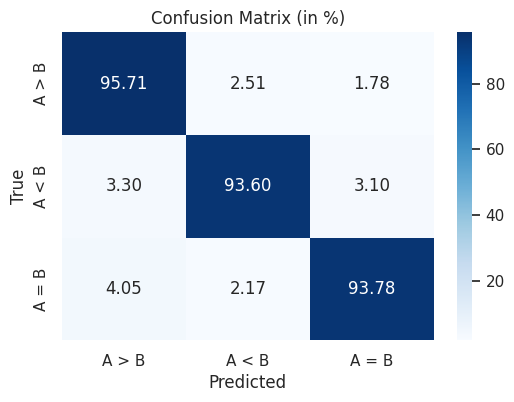

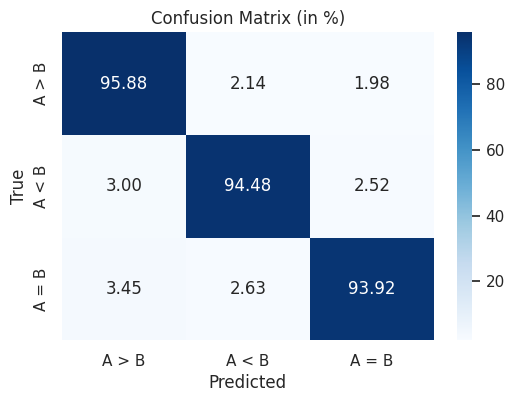

In [41]:
# Funzione per calcolare e stampare la matrice di confusione normalizzata
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Crea la matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalizza la matrice di confusione
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per ogni riga (classe vera)
    
    # Visualizza la matrice di confusione normalizzata in percentuale
    fig = plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['A > B', 'A < B', 'A = B'], 
                yticklabels=['A > B', 'A < B', 'A = B'])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (in %)')
    plt.show()

    return fig

# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', plot_confusion_matrix(model, validation_loader, device))
writer.add_figure('Confusion_matrix_test', plot_confusion_matrix(model, test_loader, device))
#plot_confusion_matrix(model, test_loader, device)


In [42]:
def classification_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Genera il report di classificazione
    report = classification_report(all_labels, all_preds, target_names=['A > B', 'A < B', 'A = B'])
    print(report)

# Stampa il report delle metriche
classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.94      0.96      0.95      2378
       A < B       0.95      0.94      0.95      2302
       A = B       0.95      0.94      0.95      2320

    accuracy                           0.95      7000
   macro avg       0.95      0.95      0.95      7000
weighted avg       0.95      0.95      0.95      7000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [43]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome del file in base agli iperparametri
    new_notebook_name = f"run_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main.ipynb')


Notebook saved as run_BS=128_LR=0.01_MOM=0.9_EPOCHS=25_AUG=False_TRA=False.ipynb


In [44]:
writer.close()